# Inactive Unit Analysis: Example

This notebook demonstrates how to run [IUA](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.IUA) on a simple dataset. For more general information about how to use DNIKit and about each of these steps, it's suggested to start with the How-To guides in the docs (starting with how to [load a model](https://apple.github.io/dnikit/how_to/connect_model.html)), and then checking out the [Familiarity Notebook for Rare Data and Data Errors](../data_introspection/familiarity_for_rare_data_discovery.ipynb).

## 1. Use DNIKit to run inference

Let us start by importing everything needed to run on this notebook.

In [1]:
from dnikit.base import pipeline, ResponseInfo
from dnikit.introspectors import IUA
from dnikit.samples import StubImageDataset
from dnikit.processors import FieldRenamer, Transposer
from dnikit.exceptions import enable_deprecation_warnings

enable_deprecation_warnings(error=True)  # treat DNIKit deprecation warnings as errors

from dnikit_tensorflow import load_tf_model_from_path

### Download a model, MobileNet, and store it locally

In [2]:
from dnikit_tensorflow import TFModelExamples

mobilenet = TFModelExamples.MobileNet()
model = mobilenet.model

2023-08-03 12:41:58.773347: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-03 12:41:58.773368: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-08-03 12:41:58.773372: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-08-03 12:41:58.773417: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-03 12:41:58.773432: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


/private/tmp/dnikit-2.0.0/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Create a Producer to generate data


In [3]:
data_producer = StubImageDataset(
    dataset_size=32,
    image_width=224,
    image_height=224,
    channel_count=3
)

### Find Convolutional Layers

In [4]:
conv2d_responses = [
    info.name
    for info in model.response_infos.values()
    if info.layer.kind is ResponseInfo.LayerKind.CONV_2D
]

### Set up processing pipeline

In [5]:
response_producer = pipeline(
    data_producer,
    FieldRenamer({"images": "input_1:0"}),
    model(conv2d_responses),
    Transposer(dim=(0, 3, 1, 2))
)

## 2. Execute IUA introspector

Which can be done with just a single line of code!

In [6]:
iua = IUA.introspect(response_producer)

### Show table of results

`IUA.show(iua)` will show, by default, a table of layers and the discovered inactive units.

In [7]:
print(IUA.show(iua).head())

     response  mean inactive  std inactive
0       conv1   100352.28125      0.571969
1   conv_dw_1    87843.43750      7.611412
2  conv_dw_10    23020.34375    417.599061
3  conv_dw_11    25536.28125    537.225699
4  conv_dw_12    10754.03125    125.383533


### Plot results

`IUA.show` can also be used to view charts, by setting `vis_type` to `IUA.VisType.CHART`.

One layer's chart can be viewed in this manner, e.g. `conv_pw_9`...

<Axes: title={'center': 'conv_pw_9 Inactive Unit Proportions '}>

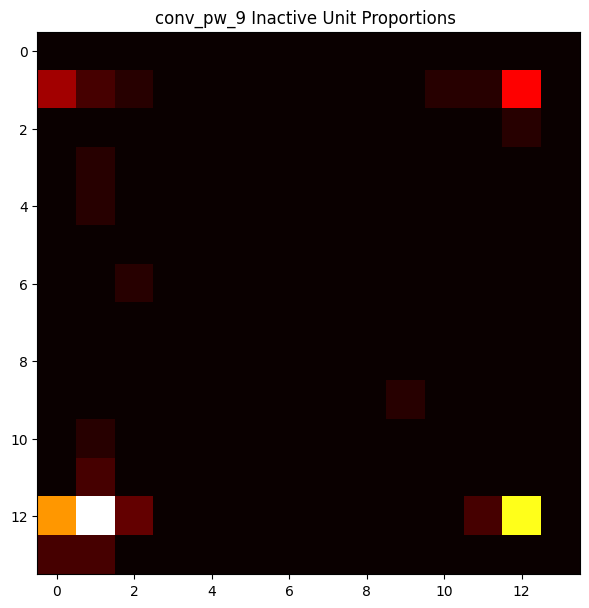

In [8]:
IUA.show(iua, vis_type=IUA.VisType.CHART, response_names=['conv_pw_9'])

... or view all responses' charts (omitting the `response_names` parameter):

array([<Axes: title={'center': 'conv1 Inactive Unit Proportions '}>,
       <Axes: title={'center': 'conv_dw_1 Inactive Unit Proportions '}>,
       <Axes: title={'center': 'conv_dw_10 Inactive Unit Proportions '}>,
       <Axes: title={'center': 'conv_dw_11 Inactive Unit Proportions '}>,
       <Axes: title={'center': 'conv_dw_12 Inactive Unit Proportions '}>,
       <Axes: title={'center': 'conv_dw_13 Inactive Unit Proportions '}>,
       <Axes: title={'center': 'conv_dw_2 Inactive Unit Proportions '}>,
       <Axes: title={'center': 'conv_dw_3 Inactive Unit Proportions '}>,
       <Axes: title={'center': 'conv_dw_4 Inactive Unit Proportions '}>,
       <Axes: title={'center': 'conv_dw_5 Inactive Unit Proportions '}>,
       <Axes: title={'center': 'conv_dw_6 Inactive Unit Proportions '}>,
       <Axes: title={'center': 'conv_dw_7 Inactive Unit Proportions '}>,
       <Axes: title={'center': 'conv_dw_8 Inactive Unit Proportions '}>,
       <Axes: title={'center': 'conv_dw_9 Inactive 

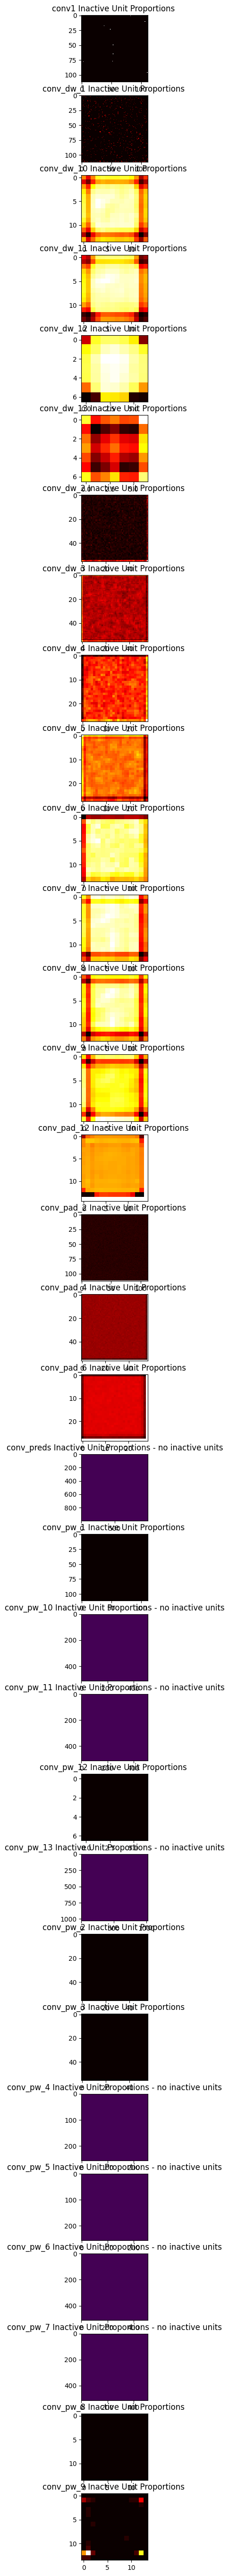

In [9]:
IUA.show(iua, vis_type=IUA.VisType.CHART)